In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from scipy import stats

In [2]:
s1 = 'E:/Old Downloads Folder/Research Stuff/Jupyter Notebooks/Coords Folder/Weather Station Coords/'

In [5]:
# This finds the initial step, stopping point, and step size of the files in your directory
def findFiles(code, filepath):

    total_steps = 0
    i = 0
    first_file = False
    final = 0
    
    # Remove parts of the filename that aren't weather station code
    with os.scandir(filepath + code) as entries:
        bad_strings = [code, '_', '.txt']
        
        for entry in entries: 
            file_name = entry.name
            for string in bad_strings: file_name = file_name.replace(string, '')
            if float(file_name) > final: final = float(file_name)
            if first_file == False:
                i = float(file_name)
                first_file = True

            total_steps += 1

    step = round((final - i)/(total_steps - 1), 5)
    print(code)
    return(i, final, step)


# Finding the R^2 value of our curve fitting prediction
# Found here: https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def findR2(fun, x, y, popt):
    residuals = y - fun(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)


# Our function!
def expFunc(x, a, b): return a*x**b


# Find the range at which our distribution has an exponent around -1 with a good R2
def findRange(code, filepath):
    i, final, step = findFiles(code, filepath)
    column_names = ['Ovito Range', 'coeff', 'exp', 'R2']
    final_frame = pd.DataFrame(columns = column_names)
    
    s2 = '/' + code + '_'
    
    best_range = 0
    best_r2 = 0
    best_diff = np.inf
    
    # The loop that does everything yeet
    while i < final:
        
        # I could not figure out how to intelligently round the numbers so make sure to check this before running!!
        i = round(i, 5)
        openpath = filepath + code + s2 + str(i) + '.txt'
        
        with open(openpath) as file:
            data = pd.read_csv(file, sep=',', names=['Size'], skiprows=[0])

        data.index = data.index + 1
        data = data.reset_index()
        xdata = data['index']
        ydata = data['Size']
        
        variables, covariance = curve_fit(expFunc, xdata, ydata)
        R2 = findR2(expFunc, xdata, ydata, variables)
        range_diff = abs(1 - abs(variables[1]))
        
        if range_diff < best_diff:
            best_diff = range_diff
            best_range = i

        i += step
        
    return best_range


# This normalized our distribution so that we can compare it to a Zipfian distribution
def normalizedDistribution(code, filepath):
    file = filepath + code + '/' + code + '_' + str(findRange(code, filepath)) + '.txt'
    data = pd.read_csv(file, sep=',', names=['Size'], skiprows=[0])
    data = data.divide(data['Size'].max())
    return data['Size'].tolist()


# This finds the max difference between any point in the building rank-size disribution and the expected value
# from a perfect exponential distribution.
def findKs(code, filepath):
    
    # This bit creates the proper Zipfian distribution
    data = normalizedDistribution(code, filepath)
    hi = len(data)
    zipDist = []
    for i in range(1, hi+1):
        zipDist.append(1/i)
#     totalVal = sum(zipDist)
#     zipDist[:] = [val/totalVal for val in zipDist]
    
    # This block finds the max difference
    maxDist = 0
    for i in range(len(data)):
        diff = abs(data[i] - zipDist[i])
        if diff > maxDist: maxDist = diff
    
    # Plot the specific weather station code you want    
#     n = 30
#     df = pd.DataFrame(dict(x=np.arange(0, hi)[:n], y=zipDist[:n]))
#     g = sns.relplot(x='x', y='y', kind='line', data=df)
#     plt.scatter(x=np.arange(0, hi)[:n], y=data[:n], c='red', s=10)
#     plt.xlabel('Rank')
#     plt.ylabel('Normalized Size')
    
    # plt.savefig('test.png')
    
    return round(maxDist, 5)

# Access the scale file of your code to find the Ovito -> Real world scale
def findScale(code, filepath):
    scale = 0
    openpath = filepath + code + '_scale.txt'
    with open(openpath) as f:
        f = f.read()
        scale = re.sub('[^0-9]', '', f)
    return float(scale)

In [21]:
import csv

s2 = s1 + 'Los Angeles/'
s3 = s1 + 'Nashville/'
s4 = s1 + 'New York/'
s5 = s1 + 'DC/'
s6 = s1 + 'SF/'
s7 = s1 + 'Denver/'
s8 = s1 + 'Las Vegas/'
s9 = s1 + 'Baltimore/'
s10 = s1 + 'Raleigh/'

ranges = []

for s in [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]:
    output = [dI for dI in os.listdir(s) if os.path.isdir(os.path.join(s ,dI))]
    for name in output:
        if name[:2] == 'US':
            ovito_range = findRange(name, s)
            scale = findScale(name, s)
            ranges.append(ovito_range * scale)

#             csv_data = normalizedDistribution(name, s)
#             save = 'Data CSVs/' + str(name) + '_zipfs_dist.csv'
#             with open(save, 'w', newline='') as myfile:
#                 wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#                 for val in csv_data:
#                     wr.writerow([val])

USC00360022
USC00360861
USC00362574
USC00365573
USC00365918
USW00014762
USW00094823
USW00023130
USW00093134
USC00408238
USW00014732
US-DC
US-SF
US-Denver
US-LV
US-Baltimore
US-Raleigh


USC00360022
USC00360022
USC00360861
USC00360861
USC00362574
USC00362574
USC00365573
USC00365573
USC00365918
USC00365918
USW00014762
USW00014762
USW00094823
USW00094823
USW00023130


E:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


USW00023130
USW00093134
USW00093134
USC00408238
USC00408238
USW00014732
USW00014732
US-DC
US-DC
US-SF
US-SF
US-Denver
US-Denver
US-LV
US-LV
US-Baltimore
US-Baltimore
US-Raleigh
US-Raleigh


,Code,Ks
0,USC00360022,0.23643
1,USC00360861,0.28702
2,USC00362574,0.16702
3,USC00365573,0.12640
4,USC00365918,0.18579
5,USW00014762,0.34534
6,USW00094823,0.27419
7,USW00023130,0.11462
8,USW00093134,0.61317
9,USC00408238,0.11296


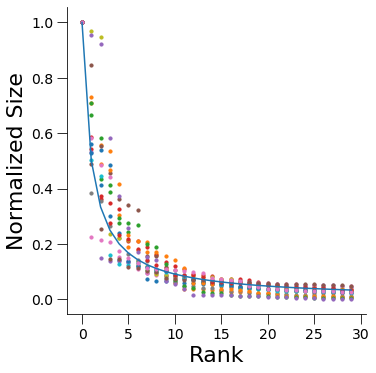

In [8]:
s2 = s1 + 'Los Angeles/'
s3 = s1 + 'Nashville/'
s4 = s1 + 'New York/'
s5 = s1 + 'DC/'
s6 = s1 + 'SF/'
s7 = s1 + 'Denver/'
s8 = s1 + 'Las Vegas/'
s9 = s1 + 'Baltimore/'
s10 = s1 + 'Raleigh/'

full_frame = pd.DataFrame(columns=['Code', 'Ks'])

zipDist = []
for i in range(1, 30+1):
    zipDist.append(1/i)

# total = sum(zipDist)
# zipDist[:] = [val/total for val in zipDist]
    
n = 30
df = pd.DataFrame(dict(x=np.arange(0, n)[:n], y=zipDist[:n]))
g = sns.relplot(x='x', y='y', kind='line', data=df)

for s in [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]:
    output = [dI for dI in os.listdir(s) if os.path.isdir(os.path.join(s ,dI))]
    for name in output:
        if name[:2] == 'US':
            temp_df = pd.DataFrame([[name, findKs(name, s)]], columns=['Code', 'Ks'])
            full_frame = full_frame.append(temp_df, ignore_index=True)  
            
            # This bit creates the proper Zipfian distribution
            data = normalizedDistribution(name, s)
            hi = len(data)
            plt.scatter(x=np.arange(0, hi)[:n], y=data[:n], s=10)

plt.xlabel('Rank', fontsize=22)
plt.ylabel('Normalized Size', fontsize=22)
plt.tick_params(length=10, labelsize=14)
            
full_frame

In [7]:
g.savefig('test.png', bbox_inches='tight')

In [17]:
full_frame

,Code,Ks
0,USC00360022,0.23643
1,USC00360861,0.28702
2,USC00362574,0.16702
3,USC00365573,0.12640
4,USC00365918,0.18579
5,USW00014762,0.34534
6,USW00094823,0.27419
7,USW00023130,0.11462
8,USW00093134,0.61317
9,USC00408238,0.11296


In [26]:
ranges.remove(max(ranges))

In [27]:
ranges

[186.048,
 235.62900000000002,
 195.43900000000002,
 145.45000000000002,
 149.022,
 186.304,
 146.05,
 194.17499999999998,
 146.43800000000002,
 164.151,
 224.48000000000002,
 169.442,
 195.075,
 125.64,
 289.769]

In [31]:
max(ranges)

289.769